In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#import pydicom as dcm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

In [2]:
images_path = 'stage_2_train_images'
train_labels_df = pd.read_csv('/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_train_labels.csv')
label_meta_data = pd.read_csv('/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_detailed_class_info.csv')

In [3]:
train_labels_df.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [4]:
label_meta_data.head(10)


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [5]:
len(np.unique(label_meta_data['patientId']))

26684

In [6]:
label_meta_data.shape

(30227, 2)

In [7]:
#Checking Missing values
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [8]:
#Merge the DF
df = pd.merge(left = label_meta_data, right = train_labels_df, how = 'left', on = 'patientId')
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [9]:
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data # return the dataframe

In [10]:
check_for_missing_data(train_labels_df)

,Total,Percent
height,20672,0.683892
width,20672,0.683892
y,20672,0.683892
x,20672,0.683892
Target,0,0.000000
patientId,0,0.000000


In [11]:
check_for_missing_data(label_meta_data)

,Total,Percent
class,0,0.0
patientId,0,0.0


In [12]:
train_labels_df.fillna(0, inplace=True)

In [13]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [14]:
train_labels_df[train_labels_df["Target"]==1].describe().T

,count,mean,std,min,25%,50%,75%,max
x,9555.0,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,366.839560,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,9555.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [15]:
np.unique(label_meta_data["class"])

array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
      dtype=object)

In [16]:
np.unique(train_labels_df["Target"])

array([0, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


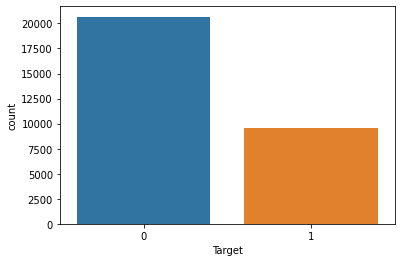

In [17]:
sns.countplot(train_labels_df["Target"])

In [18]:
train_labels_df[train_labels_df["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0


In [19]:
label_meta_data[label_meta_data['patientId']=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

#No Lung Opacity / Not Normal has been classified as Target 0

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal


In [20]:
train_labels_df[train_labels_df["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

,patientId,x,y,width,height,Target
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0


In [21]:
label_meta_data[label_meta_data['patientId']=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

#Normal is classified as Target 0 too.

,patientId,class
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal


In [22]:
train_labels_df[train_labels_df["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [23]:
label_meta_data[label_meta_data['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

#Lung Opacity has been classified as Target 1 (Pneumonia is Present)

,patientId,class
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [24]:
pd.pivot_table(df,index=["class"], values=['patientId'], aggfunc='count')

,patientId
class,
Lung Opacity,9555
No Lung Opacity / Not Normal,11821
Normal,8851


In [25]:
column_list = ["Patient ID", "Patient Sex", "Patient's Age", "View Position", "Image Size"]
file_meta_Data = pd.DataFrame(columns=column_list)

In [26]:
def add_meta_data_to_df(df, loc, from_list):
    data = []
    for filename in from_list:
            imagePath = loc+filename
            data_row_img_data = dcm.read_file(imagePath)
            values = []
            values.append(data_row_img_data.PatientID)
            values.append(data_row_img_data.PatientSex)
            values.append(data_row_img_data.PatientAge)
            values.append(data_row_img_data.ViewPosition)
            values.append(f"{data_row_img_data.Rows}x{data_row_img_data.Columns}")
            zipped_val = dict(zip(column_list, values))
            df = df.append(zipped_val, True)
    return df

In [27]:
# Images Example
train_images_dir = '/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_train_images/'
train_images = [f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]
test_images_dir = '/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_test_images/'
test_images = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5

5 Training images ['97d84e18-71f9-4b03-a80f-7cfe5a3edd19.dcm', '97d97be4-cfa6-4d2b-a1e4-854917d92b90.dcm', '97d9b14b-c7de-4294-859e-c9a5cf33044b.dcm', '97e3d9f2-fa1a-46cc-932c-b96879e199f6.dcm', '97e1f1c3-b9d4-4b02-acb0-d2ddf26cad16.dcm']


In [28]:
#!pip install pydicom

import pydicom as dcm
file_meta_Data = add_meta_data_to_df(file_meta_Data, "/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_train_images/", train_images)

KeyboardInterrupt: ignored

In [29]:
file_meta_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Patient ID     0 non-null      object
 1   Patient Sex    0 non-null      object
 2   Patient's Age  0 non-null      object
 3   View Position  0 non-null      object
 4   Image Size     0 non-null      object
dtypes: object(5)
memory usage: 0.0+ bytes


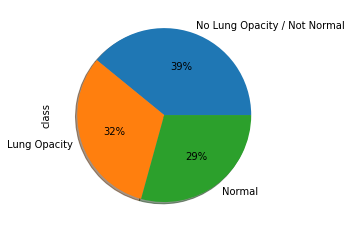

In [30]:
df["class"].value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)
plt.show()

In [31]:
sns.countplot(file_meta_Data['View Position'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


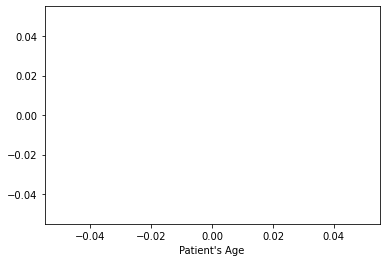

In [32]:
sns.distplot(file_meta_Data["Patient's Age"])

In [33]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 26721
Number of test images: 3000


In [34]:
#Data Visualization
import gc
gc.collect()

2609

In [35]:
#Helper function to plot dicom images
from matplotlib.patches import Rectangle

def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))

    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_train_images/{patientImage}"
        data_row_img_data = dcm.read_file(imagePath)

        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex

        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target']))
        rows = train_labels_df[train_labels_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())

        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="red",alpha = 0.1))   
    plt.show()

In [36]:
def show_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = f"/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_train_images/{patientImage}"

        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()
    

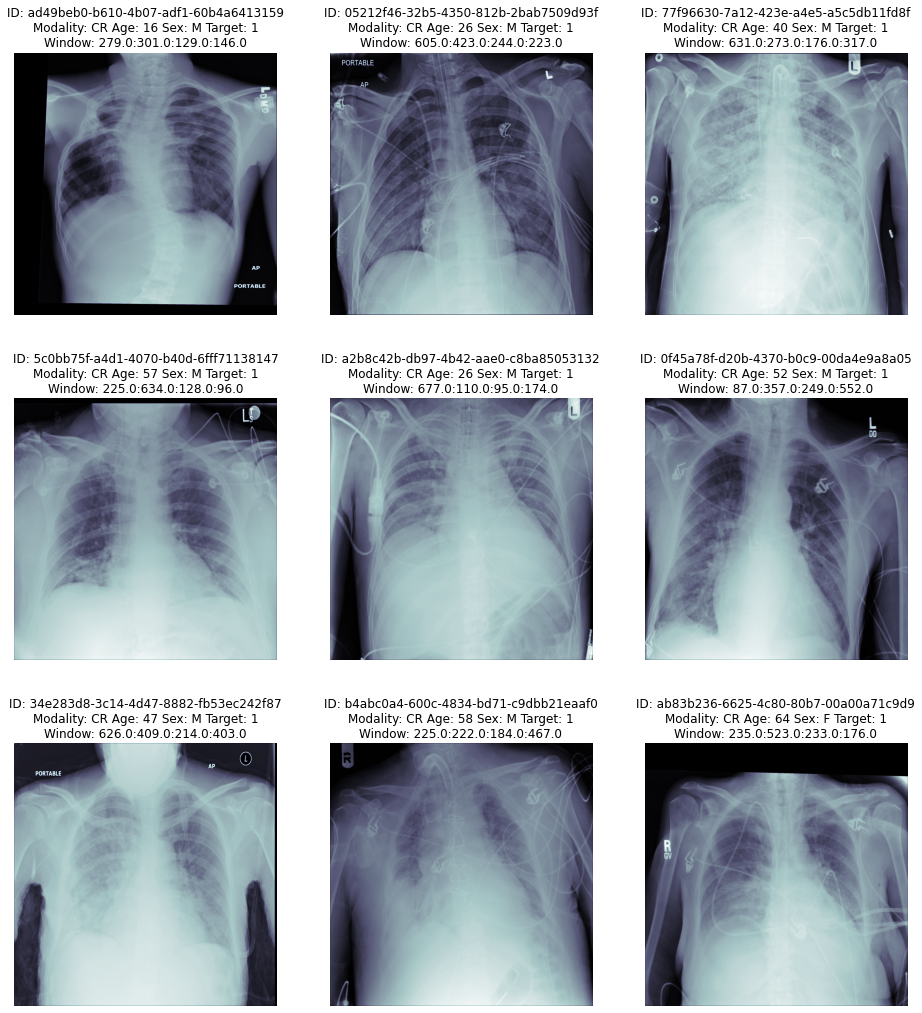

In [37]:
#Display some images

show_images(train_labels_df[train_labels_df['Target']==1].sample(9))

In [ ]:
show_images(train_labels_df[train_labels_df['Target']==0].sample(9))

In [ ]:
show_dicom_images_with_boxes(train_labels_df[train_labels_df['Target']==1].sample(9))

In [ ]:
label_meta_data[label_meta_data['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

In [ ]:
label_meta_data.drop_duplicates(subset='patientId', keep='last', inplace=True)

In [ ]:
label_meta_data.shape

In [38]:
IMAGE_SIZE = 1024 #sample_pixel_array.shape[0]
ADJUSTED_IMAGE_SIZE=224
MASK_IMAGE_SIZE = 28
FACTOR = MASK_IMAGE_SIZE/IMAGE_SIZE

In [39]:
from sklearn.utils import shuffle

label_meta_data= shuffle(label_meta_data)

In [40]:
class_train, class_val = train_test_split(label_meta_data, test_size=0.10, random_state=42, stratify=label_meta_data['class'])

In [41]:
X_feature_tr = []
y_feature_target_tr = []
y_feature_coordinates_tr = []
from PIL import Image

In [42]:
def create_mask(datafm):
    X = []
    y=[]
    masks = np.zeros((int(datafm.shape[0]), MASK_IMAGE_SIZE, MASK_IMAGE_SIZE))
    for index, patient_id in enumerate(datafm['patientId'].T.to_dict().values()):
        image_path = train_images_dir+patient_id+".dcm"
        img = dcm.read_file(image_path)
        img = img.pixel_array
        img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = preprocess_input(np.array(img, dtype=np.float32))
        X.append(img)
        rows = train_labels_df[train_labels_df['patientId']==patient_id]
        y.append(rows['Target'].values[0])

        row_data = list(rows.T.to_dict().values())
        for row in row_data:
            x1 = int(row['x']*FACTOR)
            x2 = int((row['x']*FACTOR)+(row['width']*FACTOR))
            y1 = int(row['y']*FACTOR)
            y2 = int((row['y']*FACTOR)+(row['height']*FACTOR))
            masks[index][y1:y2, x1:x2] = 1
    del img,row,row_data
    gc.collect()
    X=np.array(X)
    y=np.array(y)
    return X, y, masks

In [ ]:
#X_train, y_tr_target, y_train = create_mask(class_train)
#X_val, y_val_target, y_val = create_mask(class_val)
#y_train = create_mask(class_train)

In [ ]:
#plt.imshow(y_train[18])

In [43]:
#MODEL -DENSENET

LR = 0.005
EPOCHS = 2
BATCHSIZE = 32
CHANNELS = 64
IMAGE_SIZE = 256
NBLOCK = 6 
DEPTH = 2
MOMENTUM = 0.9

from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
import os
from matplotlib import pyplot as plt



In [44]:
import csv
import random
# Load pneumonia locations

# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
          filename = rows[0]
          location = rows[1:5]
          pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
    if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]
                
                
# Load filenames

# load and shuffle filenames
folder = '/content/drive/MyDrive/project/rsna-pneumonia-detection-challenge.zip (Unzipped Files)/stage_2_train_images'
filenames = os.listdir(folder)
filenames = filenames[:2000]
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[:1800]
valid_filenames = filenames[1800:]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 1800
n valid samples 200


In [45]:
# Data generator

class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCHSIZE, 
                 image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        #self.on_epoch_end()
    def on_epoch_end(self):
        pass
    def __load__(self, filename):
        # load dicom file as numpy array
         img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # default negative
         target = 0
        # get filename without extension
         filename = filename.split('.')[0]
        # if image contains pneumonia
         if filename in pneumonia_locations:
            target = 1
        # resize both image and mask
         img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # if augment then horizontal flip half the time
         if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
        # add trailing channel dimension
         img = np.expand_dims(img, -1)
         return img, target

         def __loadpredict__(self, filename):
        # load dicom file as numpy array
          img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
         img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
         img = np.expand_dims(img, -1)
         return img

         def __getitem__(self, index):
        # select batch
          filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
         if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
         else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, targets = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            targets = np.array(targets)
            return imgs, targets

            def on_epoch_end(self):
             if self.shuffle:
              random.shuffle(self.filenames)

         def __len__(self):
          if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
          else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size) 

In [46]:
# Network

def convlayer(channels, inputs, size=3, padding='same'):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, size, padding=padding, use_bias=False)(x)
    return x

def just_downsample(inputs, pool=2):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(pool)(x)
    return x

def convblock(inputs, channels1, channels2):
    x = convlayer(channels1, inputs)
    x = convlayer(channels2, x)
    x = keras.layers.Concatenate()([inputs, x])
    return x
def denseblock(inputs, nblocks=6, channels1=128, channels2=32):
    x = inputs
    for i in range(nblocks):
        x = convblock(x, channels1, channels2)
    x = keras.layers.SpatialDropout2D(.2)(x)
    return x

def transition(inputs, channels, pool=2):
    x = convlayer(channels, inputs)
    x = keras.layers.AveragePooling2D(pool)(x)
    return x
    
def create_network(input_size, channels=64, channels2=32, n_blocks=NBLOCK, depth=DEPTH):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', strides=2, use_bias=False)(inputs)
    x = just_downsample(x)
 # densenet blocks
    nchan = channels
    for d in range(depth-1):
        x = denseblock(x)
        nchan = ( nchan + n_blocks*channels2 ) // 2
        x = transition(x, nchan)
    x = denseblock(x)

    # output
    x = convlayer(channels, x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Dropout(.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [47]:
# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=CHANNELS, n_blocks=NBLOCK, depth=DEPTH)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  576         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [48]:
model.compile(optimizer=keras.optimizers.Adam(lr=LR),
              loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [49]:
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

#history = model.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, shuffle=True, verbose=2)

NotImplementedError: ignored